# Load data

In [4]:
import pandas as pd 
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


MC_DATA_FOLDER = '../results/MC_data_1e7'
TOTAL_NUMBER_OF_ANNIHILATIONS = 10_000_000
TOTAL_NUMBER_OF_PHOTONS = TOTAL_NUMBER_OF_ANNIHILATIONS * 2
Rs = [5.0, 10.0,15.0]
scatter_tbls  = {}
lor_tbls = {}

for R in Rs:
    try:
        lor_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/lors_*_R{int(R)}.feather"))
        phot_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/photons_*_R{int(R)}.feather"))

        lors_df = pd.concat((pd.read_feather(f) for f in lor_files), ignore_index=True)
        photons_df = pd.concat((pd.read_feather(f) for f in phot_files), ignore_index=True)
        print(f"R={R}")
        print('Number of LORs:', len(lors_df),"Number of photons", len(photons_df))
        scatter_tbls[R] = photons_df
        lor_tbls[R] = lors_df
    except Exception as e:
        print(f"Could not load data for R={R}: {e}")


R=5.0
Number of LORs: 9931300 Number of photons 20000000
R=10.0
Number of LORs: 9389901 Number of photons 20000000
R=15.0
Number of LORs: 8324892 Number of photons 20000000


# Energy spectra of scattered photons

In [5]:
COLUMNWIDTH_PT = 242.5389 # For LaTex documents 
INCH_PER_PT = 1 / 72.27 # Convert pt to inch, 1in = 72.27pt
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT 
FIG_H = FIG_W * 2.5 # aspect ratio
FONTSIZE = 10
TICKLABELSIZE=8
Rs = [5.0, 10.0, 15.0]
BIN_WIDTH = 1.0  # keV
XRNG = (0.0, 511.0)
BINS = int((XRNG[1] - XRNG[0]) / BIN_WIDTH)
print("Number of bins:", BINS)
print("Bin width:", BIN_WIDTH, " keV")
MAX_SCAT_HIST = 5

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.92

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": FONTSIZE,
    "axes.labelsize": TICKLABELSIZE,
    "xtick.labelsize": TICKLABELSIZE,
    "ytick.labelsize": TICKLABELSIZE,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.9,
    "grid.color": "white",
    "grid.linewidth": 1.,
    "axes.facecolor": "whitesmoke",
})

Number of bins: 511
Bin width: 1.0  keV


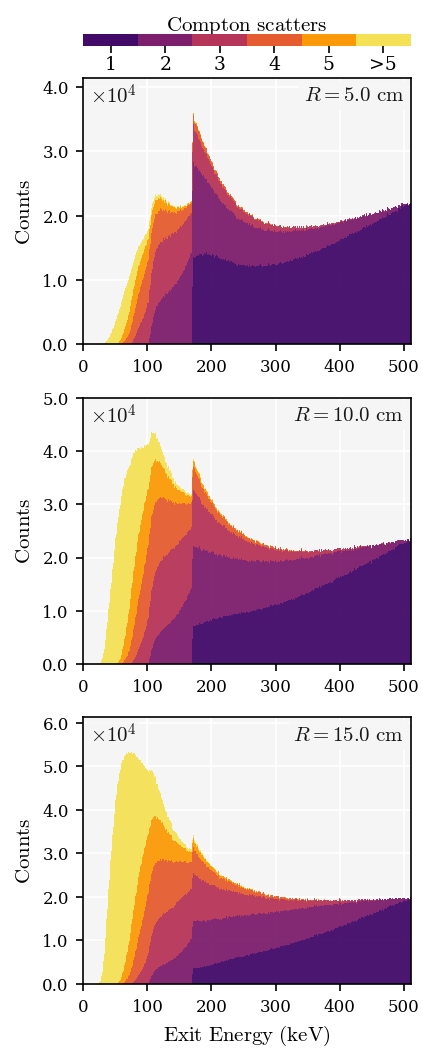

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=True)

fig.subplots_adjust(
    left=0.15,
    right=0.80,
    top=0.8,      
    bottom=0.08,
    hspace=0.20
)


_, edges = np.histogram([0.0], bins=BINS, range=XRNG)
centers = 0.5 * (edges[:-1] + edges[1:])
bw = edges[1] - edges[0]

cats_mid = None
colors_mid = None

for i, R in enumerate(Rs): # for each R
    ax = axes[i]
    lor_tbl = lor_tbls[R] # get LOR table

    n1 = lor_tbl["n_scatter_p1"].to_numpy(int) # number of scatters for photon 1
    n2 = lor_tbl["n_scatter_p2"].to_numpy(int) # number of scatters for photon 2
    e1 = lor_tbl["exit_energy_1_keV"].to_numpy(float) # exit energy for photon 1
    e2 = lor_tbl["exit_energy_2_keV"].to_numpy(float) # exit energy for photon 2

    max_s = int(max(n1.max(initial=0), n2.max(initial=0))) # maximum number of scatters
    cats = list(range(min(max_s, MAX_SCAT_HIST) + 1)) # categories of scatters
    if max_s > MAX_SCAT_HIST: # last category label " >MAX_SCAT_HIST"
        cats.append(f">{MAX_SCAT_HIST}")
    cats_plot = [c for c in cats if c != 0]

    colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, max(len(cats_plot), 1)))

    bottoms = np.zeros(BINS, float)
    total = np.zeros(BINS, float)

    for c, col in zip(cats_plot, colors):
        if isinstance(c, str): # if last category " >MAX_SCAT_HIST"
            mask1 = n1 > MAX_SCAT_HIST
            mask2 = n2 > MAX_SCAT_HIST
        else:
            mask1 = n1 == c # mask for photon 1 with c scatters Note: the absorbed photons have n_scatter -1
            mask2 = n2 == c # mask for photon 2 with c scatters

        energies = np.concatenate([e1[mask1], e2[mask2]]) # collect all energies for this category
        energies = energies[np.isfinite(energies)]
        energies = energies[energies < 511.0]

        h = np.zeros(BINS, int) if energies.size == 0 else np.histogram(
            energies, bins=BINS, range=XRNG
        )[0] # histogram of energies

        ax.bar(
            centers, h, width=bw, bottom=bottoms,
            color=col, edgecolor=col, linewidth=0.0, alpha=0.95
        ) # plot stacked bar
        bottoms += h # update bottoms for stacking
        total += h # update total

    # Formatting anf styling
    ax.set_xlim(*XRNG)
    ax.set_ylim(0, float(np.ceil(total.max() * 1.15)) if total.max() > 0 else 1.0)
    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)

    fig.canvas.draw()

    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    scale = 10.0 ** oom if oom != 0 else 1.0

    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    ax.yaxis.offsetText.set_visible(False)


    ax.text(
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.7, pad=1.2),
        zorder=10,
    )

    ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": FONTSIZE})

    ax.tick_params(labelbottom=True)
    if i == 2:
        ax.set_xlabel(r"$\mathrm{Exit~Energy~(keV)}$", fontdict={"size": FONTSIZE})

    ax.text(
        0.98, 0.97, r"$R = " + f"{R:.1f}" + r"~\mathrm{cm}$",
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )
    
    if np.isclose(R, 10.0): # DEBUG
        cats_mid = cats_plot
        colors_mid = colors

for ax in axes:
    ax.set_xticks([0, 100, 200, 300, 400, 500])


# Color bar
labels = [str(c) for c in cats_mid]
N = len(labels)

bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)

sm = mpl.cm.ScalarMappable(
    cmap=mpl.colors.ListedColormap(colors_mid),
    norm=norm
)
sm.set_array([])

top = axes[0].get_position()

cbar_h = 0.01
gap = 0.025

cax = fig.add_axes([
    top.x0,   # left
    top.y1 + gap,# bottom
    top.width, # width
    cbar_h # height
])

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    ticks=(0.5,1.5, 2.5, 3.5, 4.5, 5.5)
)
cbar.ax.set_xticklabels(labels)
cbar.set_label(r"$\mathrm{Compton~scatters}$", fontsize=FONTSIZE, labelpad=1.5)

cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=9, pad=1)

cbar.outline.set_visible(False)
cbar.ax.tick_params(which='minor', bottom=False, top=False)

# save
plt.show()
fig.savefig(
    "../results/figures/energy_spectra/scatter_stacked_all_R.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)
fig.savefig(
    "../results/figures/energy_spectra/scatter_stacked_all_R.svg",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)

